#### Análisis Exploratorio de Datos

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
# Cargar los datos desde el archivo Excel para su análisis
data = pd.read_excel('../data/data.xlsx')

In [134]:
# Mostrar los nombres de las columnas del DataFrame
data.columns

Index(['Nombre y apellidos', 'Edad', 'Sexo', 'App HTA', 'App DM', 'App AB',
       'App Cardiopatía Isquémica', 'App Vasculitis', 'App Colagenopatías',
       'Etiología del empaquetamiento', 'Número de compresas utilizadas',
       'Horas transcurridas al desempaquetamiento',
       'Daño orgánico tubular asociado', 'Peritonitis asociada',
       'Lesión de vía biliar asociada',
       'Presencia de hipotensión arterial o shock  ', 'Tiempo quirúrgico',
       '# de hemoderivados  usados', 'componentes triada letal',
       'traumas asociado', 'VAM', 'Reempaquetamiento', 'Apache II', 'Sofa',
       'Estado al egreso'],
      dtype='object')

In [135]:
# Eliminar la columna 'Nombre y apellidos' del DataFrame porque no es necesaria para el análisis
data.drop('Nombre y apellidos', axis=1, inplace = True)

#### Análisis de la Distribución de Casos 

La distribución de los resultados clínicos se analizó mediante visualización y conteos de frecuencia:

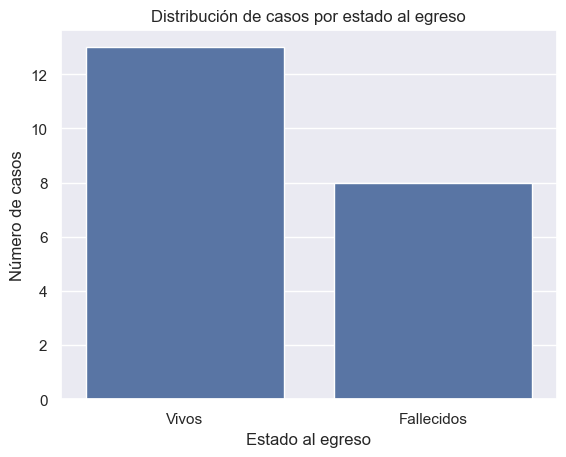

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de barras para mostrar la distribución de pacientes según su estado al egreso
sns.countplot(x='Estado al egreso', data=data)

# Título y etiquetas
plt.title('Distribución de casos por estado al egreso')
plt.xticks(ticks=[0, 1], labels=['Vivos', 'Fallecidos'])
plt.xlabel('Estado al egreso')
plt.ylabel('Número de casos')

# Guardar la figura
plt.savefig('../figures/distribucion.png', dpi=300, bbox_inches='tight')

In [137]:
# Contar la cantidad de ocurrencias de cada categoría en la columna 'Estado al egreso'
data['Estado al egreso'].value_counts()

Estado al egreso
1    13
2     8
Name: count, dtype: int64

#### Hallazgos Clave

1- Balance en la Distribución de Clases

- **Pacientes vivos:** 13 casos (61.9%)
- **Pacientes fallecidos:** 8 casos (38.1%)
- **Proporción:** 1.6:1 (Vivos:Fallecidos)

La distribución muestra un balance aceptable para modelado predictivo sin requerir técnicas agresivas de reequilibrio.

2- Características del Tamaño del Conjunto de Datos

- **Total de casos clínicos:** 21 pacientes

La clasificación como un conjunto pequeño requiere:
- Enfoques especializados de validación (por ejemplo, Validación Cruzada Leave-One-Out)
- Arquitecturas de modelo simplificadas con parámetros mínimos
- Metodologías rigurosas de selección de características
- Interpretación cuidadosa de los resultados

3- Significado Clínico

- **Tasa de mortalidad observada:** 38.1%

Esto refleja el contexto clínico de alta severidad de cirugía de control de daños y se alinea con las expectativas en la literatura para intervenciones críticas por trauma. Confirma que el conjunto de datos representa una cohorte de pacientes clínicamente relevante.


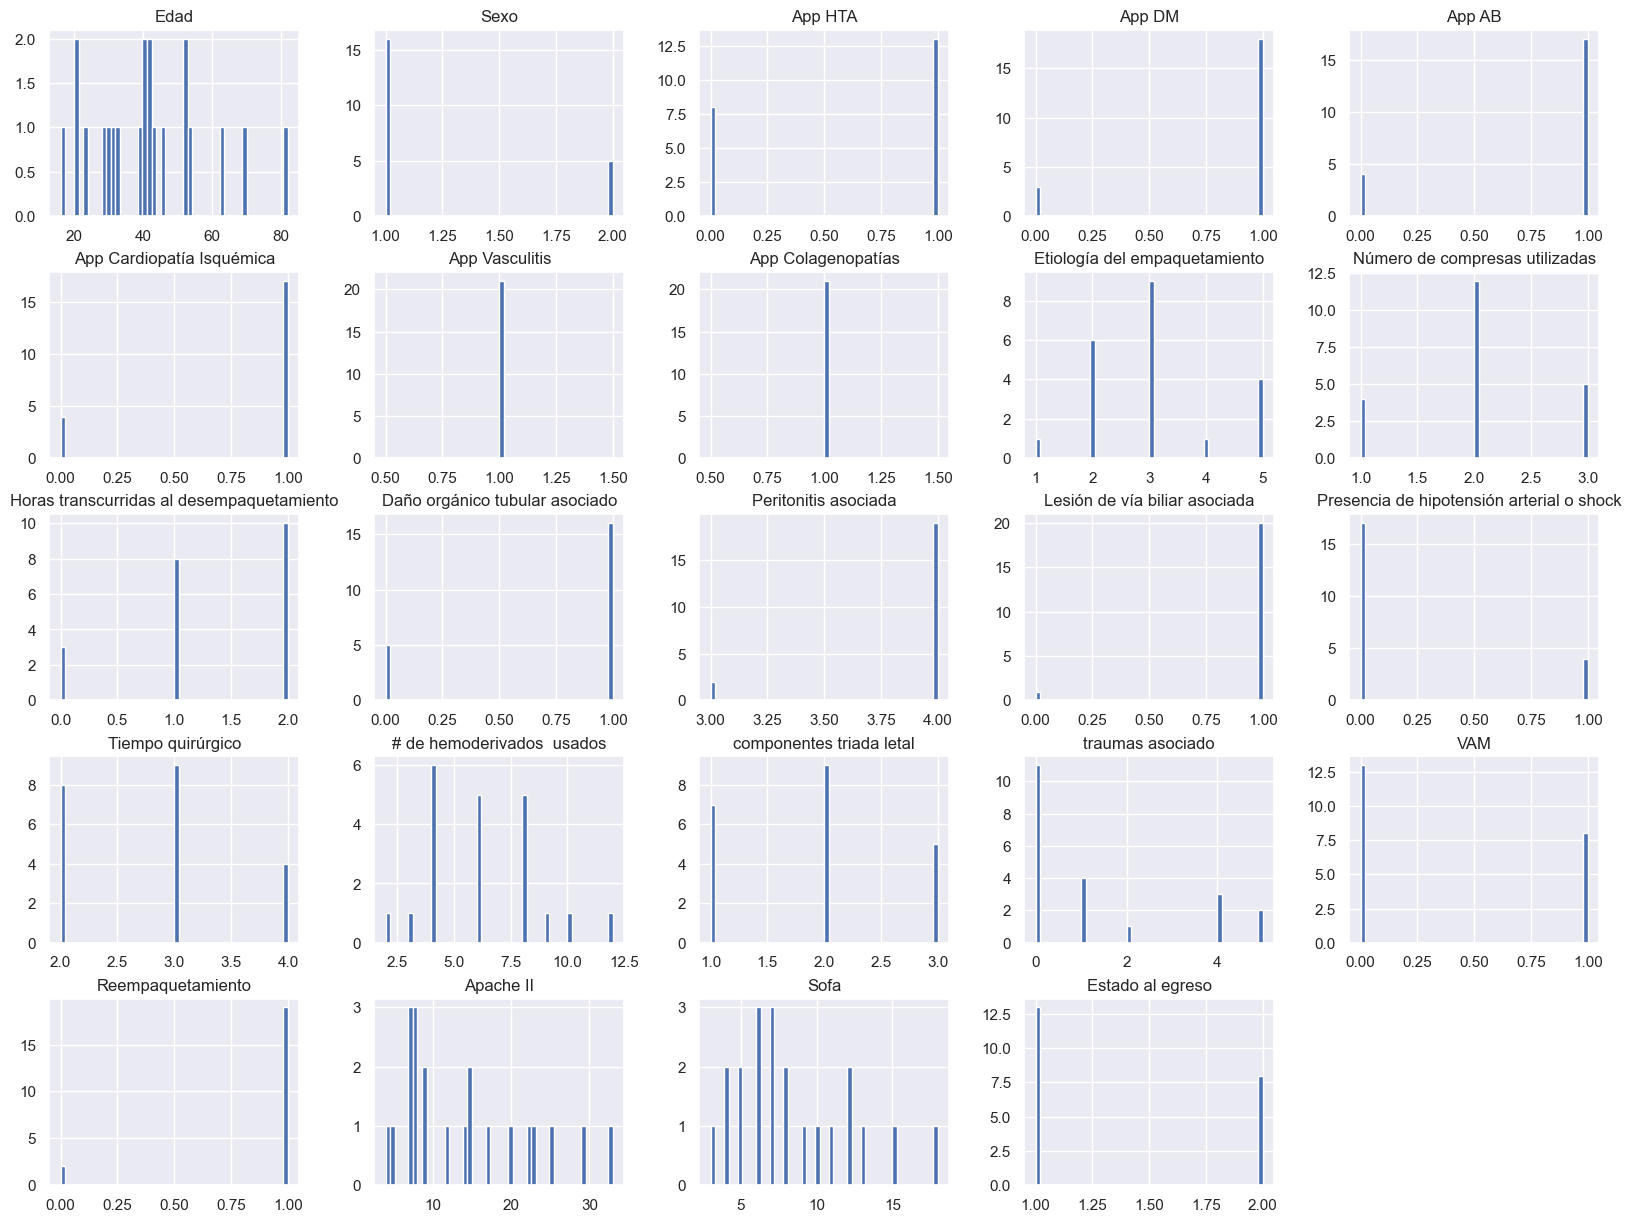

In [138]:
# Crear histogramas para todas las variables numéricas del DataFrame con 50 contenedores (bins)
data.hist(bins=50, figsize=(20,15))
plt.show()

In [139]:
# Separar la variable objetivo 'Estado al egreso' de las características predictoras
y = data['Estado al egreso']
X = data.drop('Estado al egreso', axis=1)

#### Análisis de Varianza  
Comprender la variabilidad de las características es un paso fundamental en el análisis exploratorio de datos, ya que permite identificar predictores informativos y detectar posibles problemas.

La normalización de los datos facilita una comparación equitativa de la varianza entre características que se miden en diferentes unidades, asegurando que cada variable contribuya proporcionalmente al análisis.

In [140]:
from sklearn.preprocessing import MinMaxScaler

# Crear un objeto MinMaxScaler para escalar las características al rango [0, 1]
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

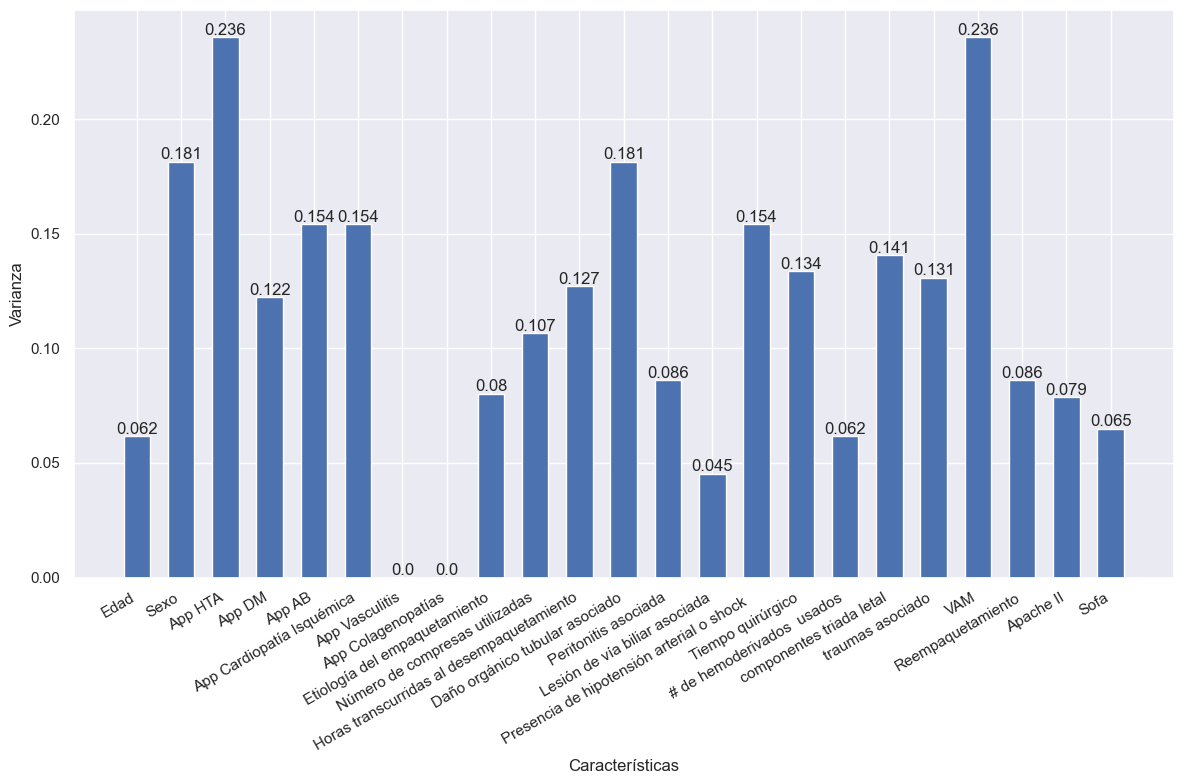

In [141]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fig.set_size_inches(12, 8)

x = X.columns
y_ = scaled_X.var(axis=0)

ax.bar(x, y_, width=0.6)
ax.set_xlabel('Características')
ax.set_ylabel('Varianza')

# Añadir etiquetas con el valor de la varianza encima de cada barra
for index, value in enumerate(y_):
    plt.text(x=index, y=value + 0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../figures/varianza.png', dpi=300, bbox_inches='tight')

In [142]:
# Eliminar las columnas 'App Vasculitis' y 'App Colagenopatías' del DataFrame
X.drop(['App Vasculitis', 'App Colagenopatías'], axis=1, inplace=True)

Se eliminaron las columnas debido a que tenían varianza cero, ya que no aportan valor informativo y contribuyen con ruido innecesario al conjunto de datos.

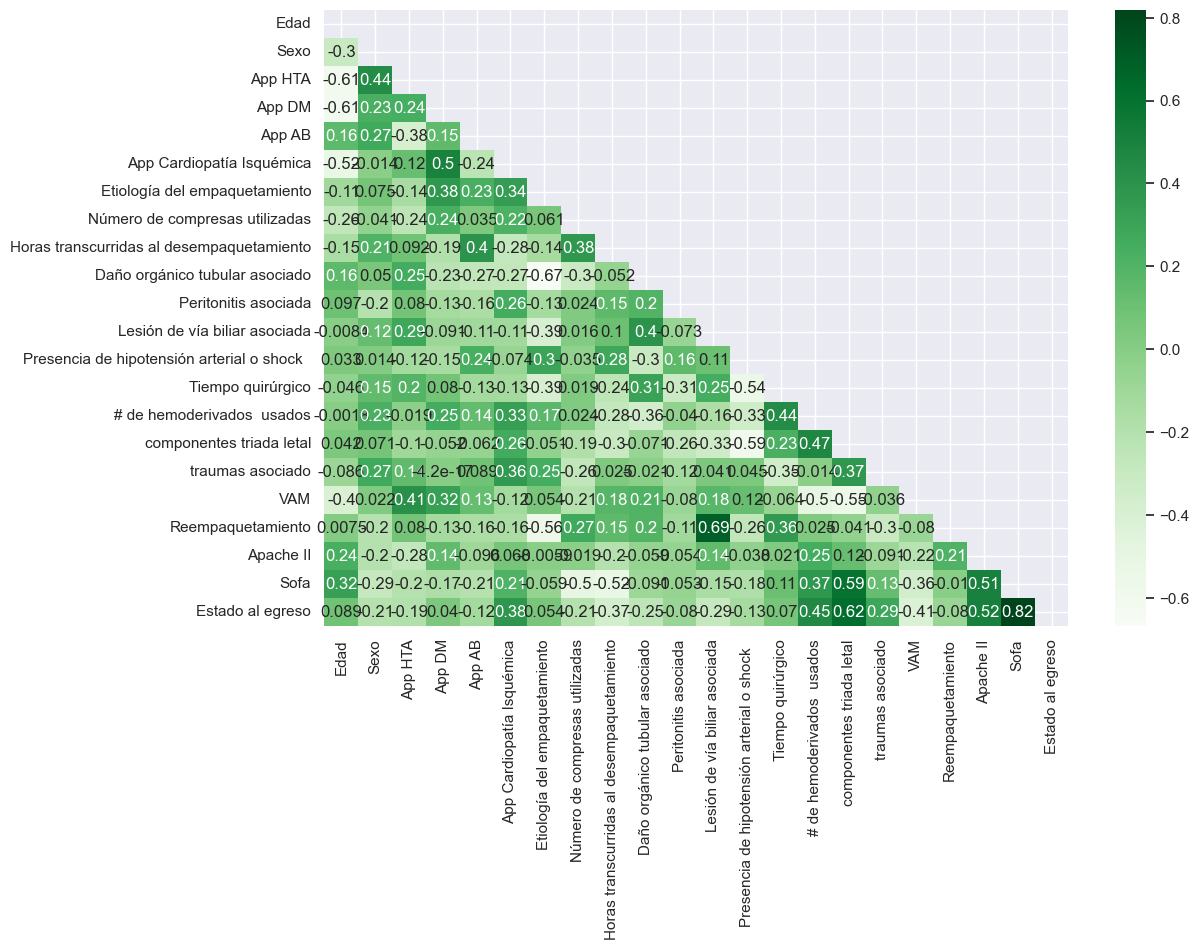

In [143]:
# Calcular la matriz de correlación entre las variables y la variable objetivo
matrix = X.join(y).corr()

# Crear una máscara para ocultar la mitad superior de la matriz
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(12,8))

# Graficar el mapa de calor con anotaciones
sns.heatmap(matrix, annot=True, cmap='Greens', mask=mask)

# Guardar la figura
plt.savefig('../figures/correlacion_global.png', dpi=300, bbox_inches='tight')


In [144]:
# Ordenar las correlaciones con 'Estado al egreso' de mayor a menor para identificar las variables más relacionadas
matrix['Estado al egreso'].sort_values(ascending=False)

Estado al egreso                               1.000000
Sofa                                           0.819522
componentes triada letal                       0.622669
Apache II                                      0.516811
# de hemoderivados  usados                     0.453623
App Cardiopatía Isquémica                      0.380521
traumas asociado                               0.289214
Edad                                           0.089428
Tiempo quirúrgico                              0.070213
Etiología del empaquetamiento                  0.053582
App DM                                         0.040032
Peritonitis asociada                          -0.079536
Reempaquetamiento                             -0.079536
App AB                                        -0.118913
Presencia de hipotensión arterial o shock     -0.130804
App HTA                                       -0.192308
Número de compresas utilizadas                -0.207397
Sexo                                          -0

### Análisis del Perfil Clínico mediante Coordenadas Paralelas

Se generó un gráfico de coordenadas paralelas para identificar de forma interactiva qué combinaciones de variables podrían servir como factores predictivos para los resultados al egreso de los pacientes, complementando así el análisis de correlación.
Cada línea representa a un paciente individual, codificada por color según el estado al egreso (verde: sobrevivió, rojo: fallecido), y los ejes verticales muestran variables clínicas normalizadas para una comparación estandarizada.

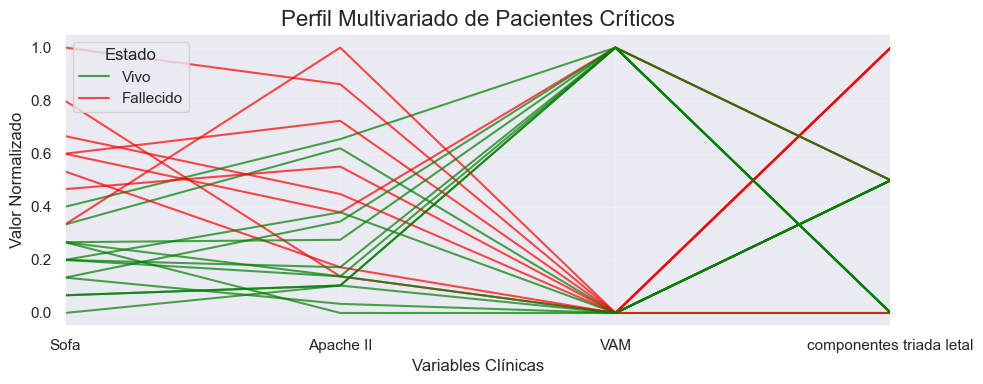

In [148]:
import matplotlib.pyplot as plt
import pandas as pd

key_vars = ['Sofa', 'Apache II', 'VAM', 'componentes triada letal', 'Estado al egreso']
subset = data[key_vars].copy()

# Columnas numéricas (todas menos la última que es categórica)
numeric_cols = key_vars[:-1]

# Escalar las variables numéricas
scaled_values = scaler.fit_transform(subset[numeric_cols].astype(float))
scaled_df = pd.DataFrame(scaled_values, columns=numeric_cols)
scaled_df['Estado al egreso'] = subset['Estado al egreso'].values

# Mapeo de colores para el estado al egreso
color_map = {1: 'green', 2: 'red'}
colors = scaled_df['Estado al egreso'].map(color_map)

plt.figure(figsize=(10, 4))
pd.plotting.parallel_coordinates(
    scaled_df,
    'Estado al egreso',
    color=colors.tolist(),
    axvlines=False,
    alpha=0.7
)

# Título y etiquetas
plt.title('Perfil Multivariado de Pacientes Críticos', fontsize=16)
plt.ylabel('Valor Normalizado', fontsize=12)
plt.xlabel('Variables Clínicas', fontsize=12)
plt.grid(alpha=0.2)
plt.legend(title='Estado', labels=['Vivo', 'Fallecido'])
plt.tight_layout()

# Guardar figura
plt.savefig('../figures/perfil_multivariado.png', dpi=300, bbox_inches='tight')


#### Interpretación:

- **Patrones de riesgo:** La agrupación de las líneas rojas (pacientes fallecidos) en rangos específicos (puntuaciones elevadas de APACHE II y SOFA) sugiere posibles umbrales asociados a la mortalidad.

- **Superposición de perfiles:** Las intersecciones entre líneas de diferentes colores indican limitaciones en el poder predictivo de variables individuales, como se observa en la variable *componentes triada letal*. 

### Análisis de la Relación entre "APACHE II" y "SOFA"

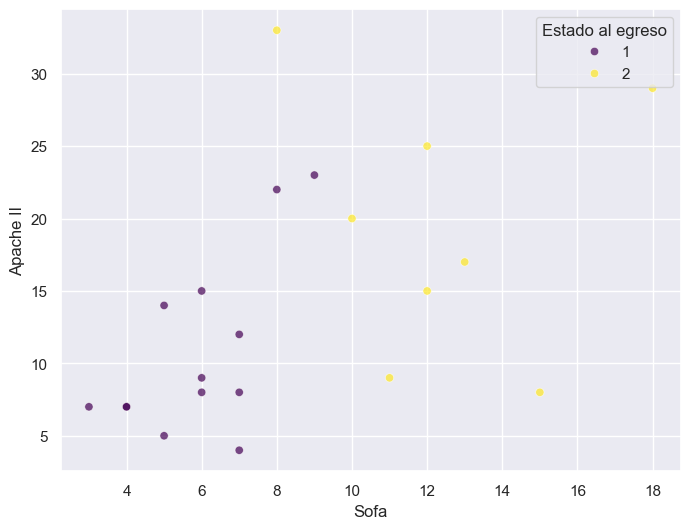

In [147]:
plt.figure(figsize=(8, 6))
sns.set(style='darkgrid')

# Crear un scatterplot para visualizar la relación entre 'Sofa' y 'Apache II', diferenciando los puntos según el 'Estado al egreso'
sns.scatterplot(x='Sofa', y ='Apache II', data = data, hue='Estado al egreso', alpha =0.7, palette='viridis')
plt.ylabel('Apache II')
plt.xlabel('Sofa')

# Guardar figura
plt.savefig('../figures/apache_vs_sofa.png', dpi=300, bbox_inches='tight')

#### Observaciones clave:

- Relación claramente no lineal entre las puntuaciones SOFA y APACHE II.

- Separación distintiva entre los grupos de resultados (sobrevivientes vs fallecidos).

- Puntuaciones más altas en ambos parámetros se correlacionan con peores desenlaces.

In [ ]:
# Unir las características con la variable objetivo y guardar el DataFrame resultante en un archivo CSV sin índice
data = X.join(y)
data.to_csv('../data/data.csv', index=False)